<a href="https://colab.research.google.com/github/ChaaruVijay/DSPL-CourseWork/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [8]:
# Load the dataset
df = pd.read_csv('cleaned_train.csv')

In [9]:
# Select features and target variable
X = df[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]
y = df['cluster_category']

In [10]:
# Encode categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [11]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Split data into training & testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [13]:
# Add Gaussian noise to training data for better generalization
noise_factor = 0.005  # Slightly reduced noise
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

In [14]:
# Define Optimized Neural Network Model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(len(label_encoder.classes_), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compile the model
optimizer = Adam(learning_rate=0.0003)  # Slightly reduced learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Callbacks: Early Stopping & Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

In [17]:
# Train the model
history = model.fit(X_train_noisy, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.8502 - loss: 0.6865 - val_accuracy: 0.9602 - val_loss: 0.1947 - learning_rate: 3.0000e-04
Epoch 2/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9575 - loss: 0.1716 - val_accuracy: 0.9680 - val_loss: 0.0957 - learning_rate: 3.0000e-04
Epoch 3/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9637 - loss: 0.0999 - val_accuracy: 0.9713 - val_loss: 0.0779 - learning_rate: 3.0000e-04
Epoch 4/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9673 - loss: 0.0846 - val_accuracy: 0.9724 - val_loss: 0.0664 - learning_rate: 3.0000e-04
Epoch 5/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.9697 - loss: 0.0772 - val_accuracy: 0.9762 - val_loss: 0.0632 - learning_rate: 3.0000e-04
Epoch 6/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9705 - loss: 0.0737 - val_accuracy: 0.9748 - val_loss: 0.0622 - learning_rate: 3.0000e-04
Epoch 7/50
2419/2419 ━━━━━━━━━━━━━━━━━━━

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

4838/4838 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9838 - loss: 0.0440
Test Loss: 0.0443
Test Accuracy: 0.9835


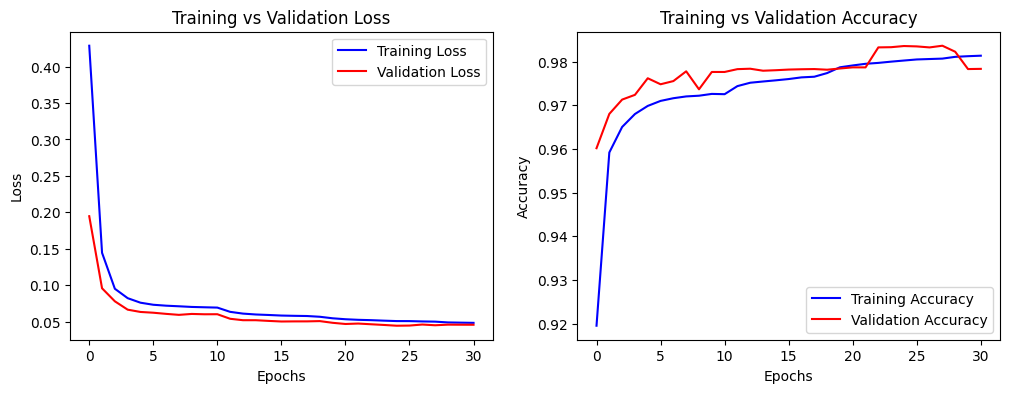

In [19]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

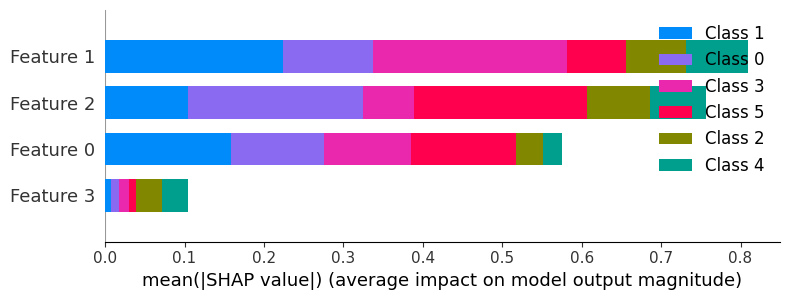

In [39]:
import shap

# SHAP Explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test[:100])  # Use a subset to reduce computation time

# Summary plot
shap.summary_plot(shap_values, X_test[:100])

In [6]:
from sklearn.inspection import permutation_importance
import numpy as np

# Use validation set for importance scoring
perm_importance = permutation_importance(model, X_val, y_val, scoring="accuracy")

# Sort by importance
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.xticks(range(len(sorted_idx)), X_val.columns[sorted_idx], rotation=90) # Assuming X_val is a pandas DataFrame
plt.title("Permutation Feature Importance")
plt.show()

NameError: name 'model' is not defined

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X_train.shape[1]}, Reduced features: {X_pca.shape[1]}")

Original features: 4, Reduced features: 4


In [20]:
# Predict probabilities
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


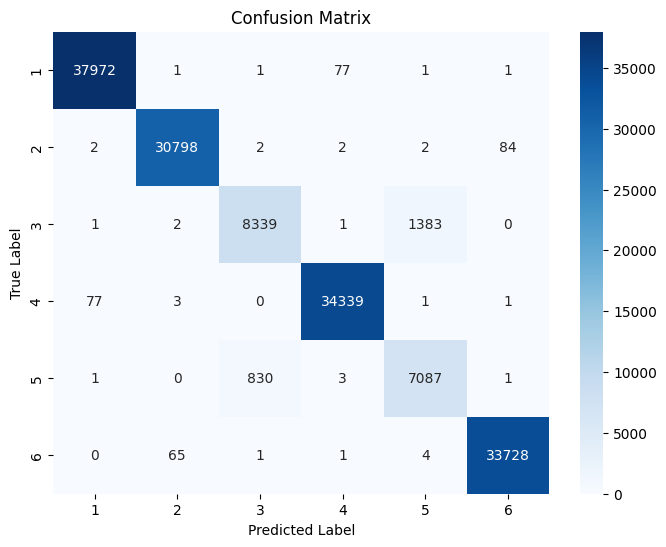

In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in label_encoder.classes_]))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     38053
           2       1.00      1.00      1.00     30890
           3       0.91      0.86      0.88      9726
           4       1.00      1.00      1.00     34421
           5       0.84      0.89      0.86      7922
           6       1.00      1.00      1.00     33799

    accuracy                           0.98    154811
   macro avg       0.96      0.96      0.96    154811
weighted avg       0.98      0.98      0.98    154811



In [34]:
# Load cleaned test dataset
cleaned_test = pd.read_csv('cleaned_test.csv')

In [35]:
# Select the same features used in training
X_cleaned_test = cleaned_test[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]

In [36]:
# Predict cluster categories
cleaned_test_predictions = model.predict(X_cleaned_test)
cleaned_test_predictions = np.argmax(cleaned_test_predictions, axis=1)

1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [37]:
# Save predictions
cleaned_test.to_csv('cleaned_test_predictions.csv', index=False)

print("Predictions saved successfully!")

Predictions saved successfully!
